# <span style='color:#0D2BA5'>Projet 6 - Classifiez automatiquement des biens de consommation : Classification supervisée</span>

## <span style='background:#33B5FF'>Table des Matieres</span>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:#33B5FF'>1. Introduction</span>

## <span style='background:#33B5FF'>2. Bibliothèques d'analyse Python</span>

In [2]:
# Chargement des librairies
import datetime
import time
import sys
import warnings
from datetime import datetime
import jyquickhelper
import numpy as np
import pandas as pd
import multiprocessing
from gensim.models import doc2vec

# Plotly Libraries
import plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib as mpl
import matplotlib.pyplot as plt
# Feature extraction
import seaborn as sns
# BERT
import transformers
from sentence_transformers import SentenceTransformer
# USE
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import KMeans
from IPython.display import display, Markdown
import gensim
from pycaret.classification import setup, compare_models, predict_model

# Warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline



2024-01-08 14:15:21.904486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Qualité Clusters
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score

In [4]:
def affiche_repartition_clusters(clusters_labels):
    '''
    Affiche la répartition par cluster
    Parameters
    ----------
    clusters_labels : la séries des labels des clusters, obligatoire.
    Returns
    -------
    None.
    '''
    ax1 = plt.gca()

    # DataFrame de travail
    series_client_cluster = pd.Series(clusters_labels).value_counts()
    nb_client = series_client_cluster.sum()
    df_visu_client_cluster = pd.DataFrame(
        {'Clusters': series_client_cluster.index,
         'Nombre': series_client_cluster.values})
    df_visu_client_cluster['%'] = round(
        (df_visu_client_cluster['Nombre']) * 100 / nb_client, 2)
    df_visu_client_cluster = df_visu_client_cluster.sort_values(by='Clusters')
    display(df_visu_client_cluster.style.hide_index())

    # Barplot de la distribution
    sns.set_style('white')
    sns.barplot(x='Clusters', y='Nombre',
                data=df_visu_client_cluster, color='SteelBlue', ax=ax1)
    ax1.set_ylabel('Nombre)', fontsize=12)
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_title('Répartition par clusters', fontsize=14)
    ax1.tick_params(axis='x', labelrotation=90)
    plt.gcf().set_size_inches(6, 4)
    plt.grid(False)
    plt.show()


In [5]:
def affiche_qualite_classification(dataframe, titre):
    '''
    Afiche heatmap de la qualité de la catégorisation et donne l'accuracy.
    Parameters
    ----------
    dataframe : dataframe, obligatoire.
    titre : type de données traitées.
    Returns
    -------
    None.
    '''
    cat_pred = dataframe['prediction_label']
    cat_reel = dataframe['CATEGORIE']

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(cat_reel, cat_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='Blues',
                yticklabels=sorted(cat_pred.unique()))
    plt.title(titre)
    plt.show()

    display(
        'Précision: {}%'.format(
            round(
                accuracy_score(
                    cat_pred,
                    cat_reel) *
                100,
                2)))
    display(Markdown(classification_report(cat_reel, cat_pred)))


In [6]:
def classifier_pycaret(data_cat, vector, titre):

    # Réduction de dimension
    tsne = TSNE(verbose=1, perplexity=50, n_iter=5000)
    X_proj_tsne = tsne.fit_transform(vector)
    # Dataframe pour clustering
    df_class = pd.DataFrame({'VAR1': X_proj_tsne[:, 0],
                             'VAR2': X_proj_tsne[:, 1],
                             'CATEGORIE': data_cat})

    # Classification PyCaret
    # Initialisation
    setup(df_class,
          target='CATEGORIE',
          session_id=21,
          log_experiment=True,
          experiment_name=titre,
          verbose = True)

    # Lancement de pycaret
    best_model = compare_models()

    # Prédictions
    df_result = predict_model(best_model)

    # Labels
    labels = df_result['prediction_label']

    # Répartition des clusters
    affiche_repartition_clusters(labels)

    # Heatmap de matrice de confusion
    affiche_qualite_classification(df_result, titre)

## <span style='background:#33B5FF'>3. chargement des données</span>

In [7]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21

In [8]:
# Chargement du jeu de données
data = pd.read_csv('data_clean.csv')
# Supprime varaible Unnamed: 0
data.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
data_cat = data['Categorie_1']

In [10]:
# Taille : nombre de lignes/colonnes
nRow, nVar = data.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1050 lignes et 9 variables.


In [11]:
# 2 premières lignes
data.head(2)

,product_name,brand,image,product_category_tree,description,product_specifications,Categorie_1,description_clean,description_token
0,Elegance Polyester Multicolor Abstract Eyelet ...,Elegance,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing >> Curtains & Accessories >> C...,Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,abstract eyelet door curtain floral curtain ab...,"['abstract', 'eyelet', 'door', 'curtain', 'flo..."
1,Sathiyas Cotton Bath Towel,Sathiyas,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,bath towel bath towel red yellow bath towel ma...,"['bath', 'towel', 'bath', 'towel', 'red', 'yel..."


## <span style='background:#33B5FF'>4. Texte + Classification Supervisée</span>

### <span style=''>4.1 BERT avec Classification supervisée</span>

In [46]:
cols = ['VAR1', 'VAR2']

In [47]:
data['description_clean'] = \
    data['description_clean'].fillna('').astype(str)
data_desc = data['description_clean']

In [48]:
# Instanciation du modèle
bert_desc_orig = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_desc_orig = bert_desc_orig.encode(data_desc)

No sentence-transformers model found with name /Users/habiba/.cache/torch/sentence_transformers/roberta-large. Creating a new one with MEAN pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at /Users/habiba/.cache/torch/sentence_transformers/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
titre = 'TSNE_ROBERTA_DESC'

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.015s...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] Computed neighbors for 1050 samples in 0.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.172234
[t-SNE] KL divergence after 5000 iterations: 0.800305


,Description,Value
0,Session id,21
1,Target,CATEGORIE
2,Target type,Multiclass
3,Target mapping,"Baby Care: 0, Beauty and Personal Care: 1, Computers: 2, Home Decor & Festive Needs: 3, Home Furnishing: 4, Kitchen & Dining: 5, Watches: 6"
4,Original data shape,"(1050, 3)"
5,Transformed data shape,"(1050, 3)"
6,Transformed train set shape,"(735, 3)"
7,Transformed test set shape,"(315, 3)"
8,Numeric features,2
9,Preprocess,True


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7267,0.9147,0.7267,0.7374,0.7252,0.6811,0.6833,0.4010
rf,Random Forest Classifier,0.6994,0.9127,0.6994,0.7076,0.6982,0.6493,0.6509,0.4060
knn,K Neighbors Classifier,0.6912,0.8951,0.6912,0.7077,0.6907,0.6397,0.6424,0.2120
catboost,CatBoost Classifier,0.6791,0.9122,0.6791,0.6908,0.6757,0.6257,0.6284,2.2580
lightgbm,Light Gradient Boosting Machine,0.6573,0.9089,0.6573,0.6696,0.6570,0.6001,0.6019,1.2010
dt,Decision Tree Classifier,0.6436,0.7919,0.6436,0.6592,0.6440,0.5842,0.5862,0.1660
xgboost,Extreme Gradient Boosting,0.6395,0.9034,0.6395,0.6438,0.6354,0.5794,0.5812,0.3660
gbc,Gradient Boosting Classifier,0.5906,0.8729,0.5906,0.5992,0.5859,0.5223,0.5249,1.2560
qda,Quadratic Discriminant Analysis,0.3673,0.7354,0.3673,0.3358,0.3264,0.2619,0.2707,0.1660
nb,Naive Bayes,0.3305,0.7292,0.3305,0.3002,0.2892,0.2193,0.2263,0.1880


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7175,0.9098,0,0,0,0.6704,0.6712


Clusters,Nombre,%
Baby Care,38,12.060000
Beauty and Personal Care,36,11.430000
Computers,47,14.920000
Home Decor & Festive Needs,51,16.190000
Home Furnishing,49,15.560000
Kitchen & Dining,44,13.970000
Watches,50,15.870000


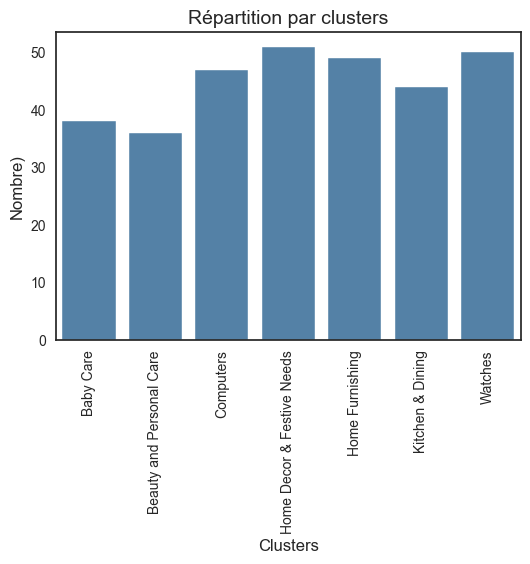

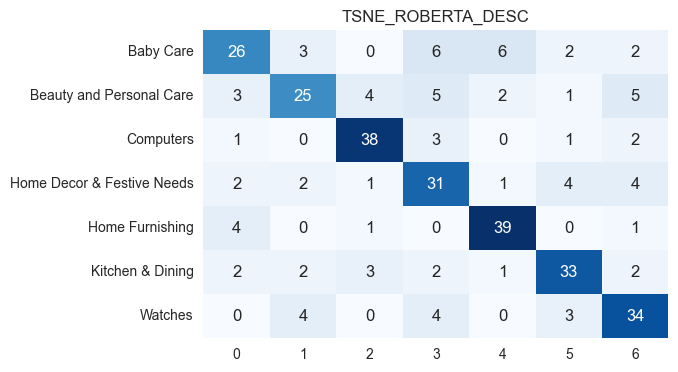

'Précision: 71.75%'

                            precision    recall  f1-score   support

                 Baby Care       0.68      0.58      0.63        45
  Beauty and Personal Care       0.69      0.56      0.62        45
                 Computers       0.81      0.84      0.83        45
Home Decor & Festive Needs       0.61      0.69      0.65        45
           Home Furnishing       0.80      0.87      0.83        45
          Kitchen & Dining       0.75      0.73      0.74        45
                   Watches       0.68      0.76      0.72        45

                  accuracy                           0.72       315
                 macro avg       0.72      0.72      0.71       315
              weighted avg       0.72      0.72      0.71       315


In [50]:
classifier_pycaret(data_cat, vector_roberta_desc_orig, titre)

In [54]:
def sauvegarder_accuracy_pycaret(dataframe, score_train, score_test, titre):
    '''

    Parameters
    ----------
    dataframe : TYPE
        DESCRIPTION.
    score_train : TYPE
        DESCRIPTION.
    score_test : TYPE
        DESCRIPTION.
    titre : TYPE
        DESCRIPTION.

    Returns
    -------
    dataframe_metrics : TYPE
        DESCRIPTION.
    '''
    dataframe_metrics = dataframe._append(pd.DataFrame({
        'Type_données': [titre],
        'Accuracy_train': [score_train],
        'Accuracy_test': [score_test]
    }), ignore_index=True)

    dataframe_metrics.to_csv('data_accuracy_classification.csv')

    return dataframe_metrics

In [55]:
df_accuracy_class = pd.DataFrame({})

In [90]:
# Sauvegarde des résultats
df_accuracy_class =sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7267', '0.7175', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
4,TSNE_XCEPTION,0.8382,0.8159
5,TSNE_XCEPTION,0.8476,0.7937
6,TSNE_XCEPTION,0.7267,0.7175


### <span style=''>4.2 USE avec Classification supervisée</span>

In [57]:
use_module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [58]:
# Chargement du modèle
use_model_prod_orig = hub.load(use_module_url)
print('Module %s Chargé' % use_module_url)

Module https://tfhub.dev/google/universal-sentence-encoder/4 Chargé


In [59]:
vector_use_desc = use_model_prod_orig(data_desc)

In [60]:
titre = 'TSNE_USE_DESC'

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.069328
[t-SNE] KL divergence after 4700 iterations: 0.955684


,Description,Value
0,Session id,21
1,Target,CATEGORIE
2,Target type,Multiclass
3,Target mapping,"Baby Care: 0, Beauty and Personal Care: 1, Computers: 2, Home Decor & Festive Needs: 3, Home Furnishing: 4, Kitchen & Dining: 5, Watches: 6"
4,Original data shape,"(1050, 3)"
5,Transformed data shape,"(1050, 3)"
6,Transformed train set shape,"(735, 3)"
7,Transformed test set shape,"(315, 3)"
8,Numeric features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7702,0.9393,0.7702,0.7802,0.7689,0.7318,0.7340,0.4990
rf,Random Forest Classifier,0.7484,0.9368,0.7484,0.7591,0.7476,0.7063,0.7083,0.5790
xgboost,Extreme Gradient Boosting,0.7430,0.9366,0.7430,0.7559,0.7429,0.7001,0.7021,0.3870
catboost,CatBoost Classifier,0.7389,0.9391,0.7389,0.7500,0.7377,0.6953,0.6974,2.4980
lightgbm,Light Gradient Boosting Machine,0.7267,0.9343,0.7267,0.7398,0.7261,0.6810,0.6831,1.7420
knn,K Neighbors Classifier,0.7185,0.9142,0.7185,0.7354,0.7177,0.6715,0.6746,0.3100
dt,Decision Tree Classifier,0.6967,0.8249,0.6967,0.7209,0.6965,0.6460,0.6496,0.2580
gbc,Gradient Boosting Classifier,0.6899,0.9177,0.6899,0.7023,0.6880,0.6382,0.6406,1.7320
qda,Quadratic Discriminant Analysis,0.4326,0.7728,0.4326,0.3924,0.3910,0.3379,0.3473,0.2610
nb,Naive Bayes,0.4041,0.7657,0.4041,0.3638,0.3669,0.3045,0.3117,0.2260


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7619,0.9194,0,0,0,0.7222,0.7234


Clusters,Nombre,%
Baby Care,39,12.380000
Beauty and Personal Care,40,12.700000
Computers,49,15.560000
Home Decor & Festive Needs,36,11.430000
Home Furnishing,52,16.510000
Kitchen & Dining,46,14.600000
Watches,53,16.830000


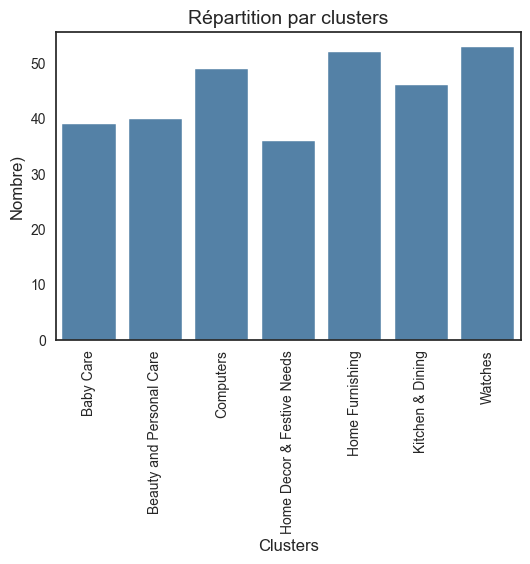

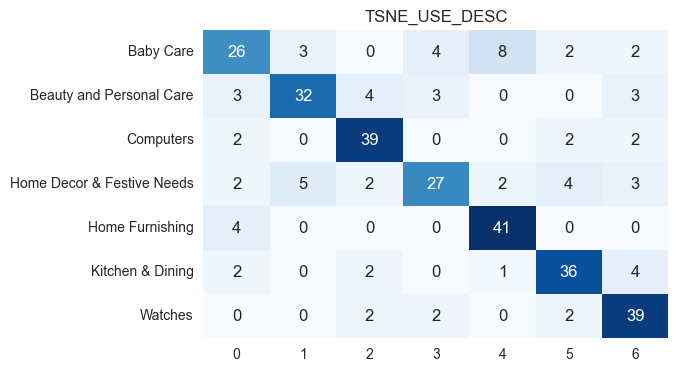

'Précision: 76.19%'

                            precision    recall  f1-score   support

                 Baby Care       0.67      0.58      0.62        45
  Beauty and Personal Care       0.80      0.71      0.75        45
                 Computers       0.80      0.87      0.83        45
Home Decor & Festive Needs       0.75      0.60      0.67        45
           Home Furnishing       0.79      0.91      0.85        45
          Kitchen & Dining       0.78      0.80      0.79        45
                   Watches       0.74      0.87      0.80        45

                  accuracy                           0.76       315
                 macro avg       0.76      0.76      0.76       315
              weighted avg       0.76      0.76      0.76       315


In [61]:
classifier_pycaret(data_cat, vector_use_desc, titre)

In [63]:
# Sauvegarde des résultats
df_accuracy_class =sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7702', '0.7619', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
1,TSNE_USE_DESC,0.7729,0.7429
2,TSNE_USE_DESC,0.7702,0.7619


## <span style='background:#33B5FF'>5. Images + Classification Supervisée approche Reseaux de neurones</span>

### <span style=''>5.1 VGG16 avec Classification supervisée</span>

In [64]:
import pickle

In [65]:
with open('df_vgg16_vectors.pickle', 'rb') as vectors:
    df_vgg16_vectors = pickle.load(vectors)

In [66]:
titre = 'TSNE_VGG16'

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.697s...
[t-SNE] Computed neighbors for 1050 samples in 2.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 489.895712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.700531
[t-SNE] KL divergence after 4650 iterations: 1.485603


,Description,Value
0,Session id,21
1,Target,CATEGORIE
2,Target type,Multiclass
3,Target mapping,"Baby Care: 0, Beauty and Personal Care: 1, Computers: 2, Home Decor & Festive Needs: 3, Home Furnishing: 4, Kitchen & Dining: 5, Watches: 6"
4,Original data shape,"(1050, 3)"
5,Transformed data shape,"(1050, 3)"
6,Transformed train set shape,"(735, 3)"
7,Transformed test set shape,"(315, 3)"
8,Numeric features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7239,0.9191,0.7239,0.7480,0.7222,0.6779,0.6819,0.5910
catboost,CatBoost Classifier,0.7185,0.9266,0.7185,0.7393,0.7160,0.6716,0.6757,2.5580
et,Extra Trees Classifier,0.7144,0.9200,0.7144,0.7295,0.7108,0.6667,0.6702,0.4820
xgboost,Extreme Gradient Boosting,0.6941,0.9216,0.6941,0.7007,0.6903,0.6430,0.6453,0.5060
lightgbm,Light Gradient Boosting Machine,0.6940,0.9251,0.6940,0.7100,0.6887,0.6430,0.6470,1.5210
knn,K Neighbors Classifier,0.6927,0.8946,0.6927,0.7132,0.6926,0.6415,0.6447,0.2800
gbc,Gradient Boosting Classifier,0.6763,0.9123,0.6763,0.7009,0.6756,0.6222,0.6262,1.5580
dt,Decision Tree Classifier,0.6750,0.8105,0.6750,0.6899,0.6697,0.6208,0.6250,0.2840
nb,Naive Bayes,0.6191,0.8667,0.6191,0.6549,0.6193,0.5556,0.5607,0.2950
qda,Quadratic Discriminant Analysis,0.6191,0.8756,0.6191,0.6428,0.6160,0.5556,0.5602,0.2700


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7143,0.9173,0,0,0,0.6667,0.6677


Clusters,Nombre,%
Baby Care,47,14.920000
Beauty and Personal Care,34,10.790000
Computers,49,15.560000
Home Decor & Festive Needs,51,16.190000
Home Furnishing,42,13.330000
Kitchen & Dining,52,16.510000
Watches,40,12.700000


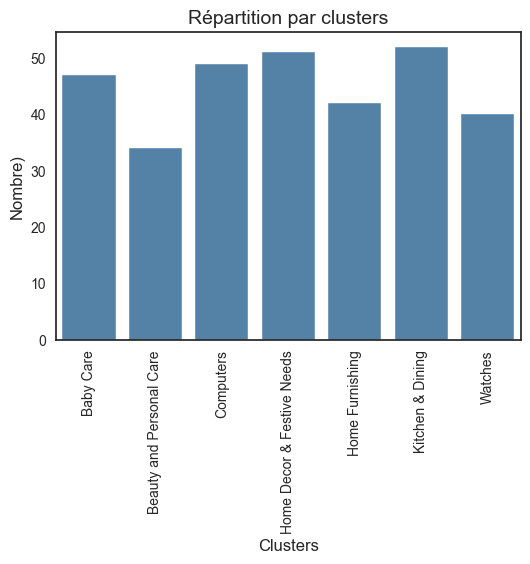

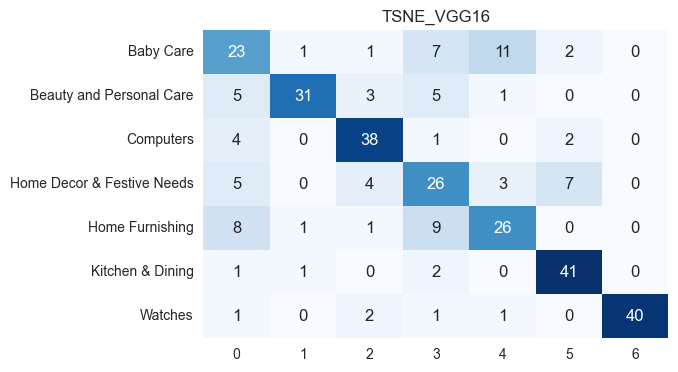

'Précision: 71.43%'

                            precision    recall  f1-score   support

                 Baby Care       0.49      0.51      0.50        45
  Beauty and Personal Care       0.91      0.69      0.78        45
                 Computers       0.78      0.84      0.81        45
Home Decor & Festive Needs       0.51      0.58      0.54        45
           Home Furnishing       0.62      0.58      0.60        45
          Kitchen & Dining       0.79      0.91      0.85        45
                   Watches       1.00      0.89      0.94        45

                  accuracy                           0.71       315
                 macro avg       0.73      0.71      0.72       315
              weighted avg       0.73      0.71      0.72       315


In [67]:
classifier_pycaret(data_cat, df_vgg16_vectors, titre)

In [68]:
# Sauvegarde des résultats
df_accuracy_class = sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.7239', '0.7143', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
3,TSNE_VGG16,0.7239,0.7143


**Exemple d'optimisation de parametres**


In [69]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(df_vgg16_vectors,data_cat, test_size=0.25, stratify=data_cat, random_state=1944)

In [70]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(Xtrain.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [71]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
from sklearn.preprocessing import OneHotEncoder

one_hot_ytrain = np.array(pd.get_dummies(ytrain))
one_hot_ytest = np.array(pd.get_dummies(ytest))
column_dum = pd.get_dummies(ytrain).columns

In [73]:
Xtrain_array = np.array(Xtrain)
Xtest_array = np.array(Xtest)

In [74]:
history = model.fit(Xtrain_array,
                    one_hot_ytrain,
                    epochs=10,
                    batch_size=150,
                    validation_data=(Xtest_array, one_hot_ytest))

Epoch 1/10
6/6 [==============================] - 2s 134ms/step - loss: 71.5828 - accuracy: 0.2859 - val_loss: 9.5168 - val_accuracy: 0.5856
Epoch 2/10
6/6 [==============================] - 0s 73ms/step - loss: 3.4406 - accuracy: 0.7776 - val_loss: 9.6377 - val_accuracy: 0.6654
Epoch 3/10
6/6 [==============================] - 0s 78ms/step - loss: 1.0122 - accuracy: 0.9072 - val_loss: 5.0429 - val_accuracy: 0.7376
Epoch 4/10
6/6 [==============================] - 1s 98ms/step - loss: 0.2613 - accuracy: 0.9644 - val_loss: 4.8091 - val_accuracy: 0.7643
Epoch 5/10
6/6 [==============================] - 0s 75ms/step - loss: 0.0286 - accuracy: 0.9949 - val_loss: 4.9635 - val_accuracy: 0.7681
Epoch 6/10
6/6 [==============================] - 1s 99ms/step - loss: 0.0292 - accuracy: 0.9987 - val_loss: 5.2317 - val_accuracy: 0.7643
Epoch 7/10
6/6 [==============================] - 0s 88ms/step - loss: 0.0170 - accuracy: 0.9987 - val_loss: 5.0888 - val_accuracy: 0.7643
Epoch 8/10
6/6 [=========

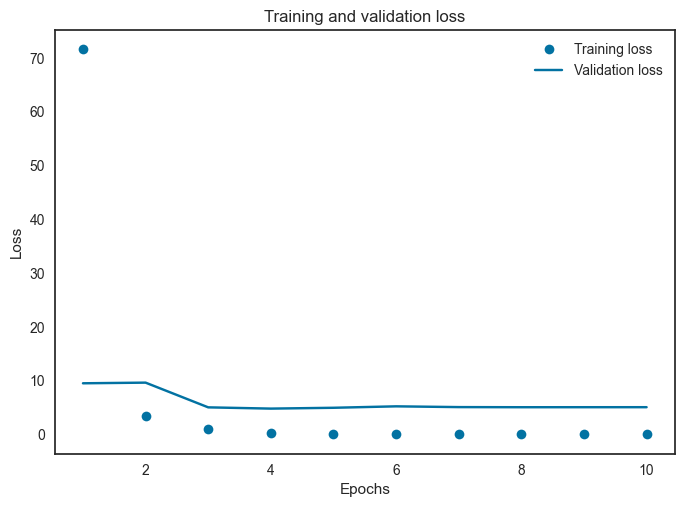

In [75]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [76]:
ypred = model.predict(Xtest_array)

9/9 [==============================] - 0s 5ms/step


In [77]:
ypred_argmax = []
for i,elt in enumerate(ypred):
    ypred_argmax.append(np.argmax(elt))
    

In [78]:
# creation d'un variable numerique pour la categorie

from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
categ = label_enc.fit_transform(data_cat)
label_enc.inverse_transform([0,1,2,3,4,5,6])

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [79]:
ytest_encode = label_enc.transform(ytest)

In [80]:
display(
    'Précision: {}%'.format(
        round(
            accuracy_score(
                ytest_encode,
                ypred_argmax) *
            100,
            2)))
display(Markdown(classification_report(ytest_encode, ypred_argmax)))


'Précision: 77.19%'

              precision    recall  f1-score   support

           0       0.62      0.66      0.64        38
           1       0.93      0.68      0.78        37
           2       0.72      0.74      0.73        38
           3       0.65      0.79      0.71        38
           4       0.76      0.74      0.75        38
           5       0.86      0.81      0.83        37
           6       0.95      1.00      0.97        37

    accuracy                           0.77       263
   macro avg       0.78      0.77      0.77       263
weighted avg       0.78      0.77      0.77       263


### <span style=''>5.2 Xception avec Classification supervisée</span>

In [81]:
with open('df_xcept_vectors.pickle', 'rb') as vectors:
    df_xcept_vectors = pickle.load(vectors)

In [82]:
titre = 'TSNE_XCEPTION'

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 2.384s...
[t-SNE] Computed neighbors for 1050 samples in 11.726s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 49.320518
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.628094
[t-SNE] KL divergence after 4900 iterations: 0.959444


,Description,Value
0,Session id,21
1,Target,CATEGORIE
2,Target type,Multiclass
3,Target mapping,"Baby Care: 0, Beauty and Personal Care: 1, Computers: 2, Home Decor & Festive Needs: 3, Home Furnishing: 4, Kitchen & Dining: 5, Watches: 6"
4,Original data shape,"(1050, 3)"
5,Transformed data shape,"(1050, 3)"
6,Transformed train set shape,"(735, 3)"
7,Transformed test set shape,"(315, 3)"
8,Numeric features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8476,0.9601,0.8476,0.8538,0.8446,0.8223,0.8243,0.5000
rf,Random Forest Classifier,0.8245,0.9577,0.8245,0.8336,0.8207,0.7953,0.7981,0.5800
catboost,CatBoost Classifier,0.8191,0.9664,0.8191,0.8273,0.8163,0.7889,0.7911,3.2110
knn,K Neighbors Classifier,0.8150,0.9470,0.8150,0.8236,0.8121,0.7842,0.7866,0.3280
xgboost,Extreme Gradient Boosting,0.8137,0.9641,0.8137,0.8229,0.8114,0.7826,0.7849,0.4100
lightgbm,Light Gradient Boosting Machine,0.8041,0.9609,0.8041,0.8136,0.8012,0.7715,0.7741,3.1520
gbc,Gradient Boosting Classifier,0.8001,0.9568,0.8001,0.8092,0.7983,0.7667,0.7688,1.8050
dt,Decision Tree Classifier,0.7891,0.8771,0.7891,0.8091,0.7874,0.7539,0.7583,0.4330
qda,Quadratic Discriminant Analysis,0.7470,0.9255,0.7470,0.7668,0.7410,0.7048,0.7097,0.2700
nb,Naive Bayes,0.7416,0.9228,0.7416,0.7570,0.7356,0.6985,0.7027,0.4150


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7937,0.9423,0,0,0,0.7593,0.7615


Clusters,Nombre,%
Baby Care,31,9.840000
Beauty and Personal Care,37,11.750000
Computers,48,15.240000
Home Decor & Festive Needs,51,16.190000
Home Furnishing,59,18.730000
Kitchen & Dining,43,13.650000
Watches,46,14.600000


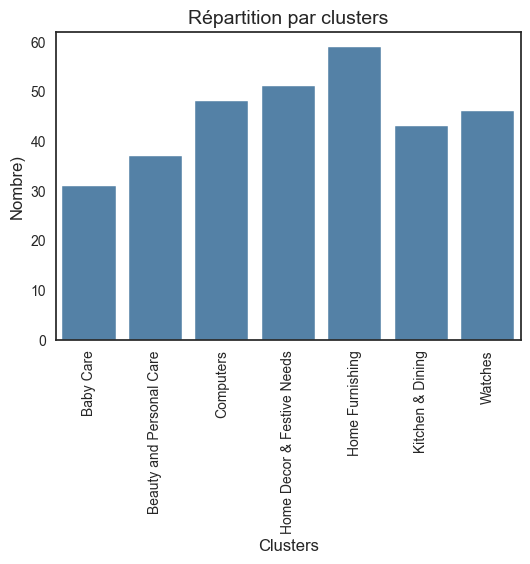

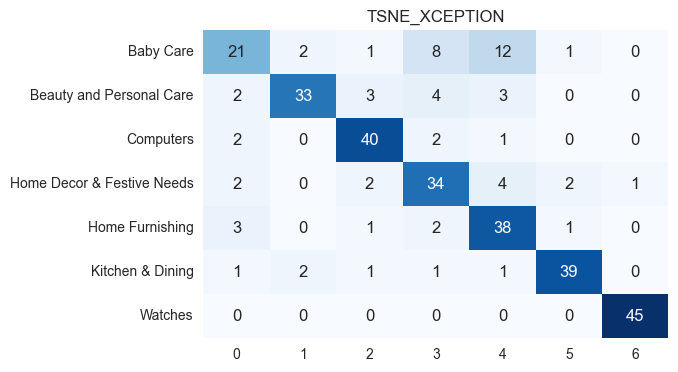

'Précision: 79.37%'

                            precision    recall  f1-score   support

                 Baby Care       0.68      0.47      0.55        45
  Beauty and Personal Care       0.89      0.73      0.80        45
                 Computers       0.83      0.89      0.86        45
Home Decor & Festive Needs       0.67      0.76      0.71        45
           Home Furnishing       0.64      0.84      0.73        45
          Kitchen & Dining       0.91      0.87      0.89        45
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.79       315
                 macro avg       0.80      0.79      0.79       315
              weighted avg       0.80      0.79      0.79       315


In [83]:
classifier_pycaret(data_cat, df_xcept_vectors, titre)

In [87]:
# Sauvegarde des résultats
df_accuracy_class = sauvegarder_accuracy_pycaret(df_accuracy_class,
                                               '0.8476', '0.7937', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
4,TSNE_XCEPTION,0.8382,0.8159
5,TSNE_XCEPTION,0.8476,0.7937


In [88]:
dt = pd.read_csv('data_accuracy_classification.csv')

In [89]:
dt.head()

,Unnamed: 0,Type_données,Accuracy_train,Accuracy_test
0,0,TSNE_ROBERTA_DESC,0.7267,0.7175
1,1,TSNE_USE_DESC,0.7729,0.7429
2,2,TSNE_USE_DESC,0.7702,0.7619
3,3,TSNE_VGG16,0.7239,0.7143
4,4,TSNE_XCEPTION,0.8382,0.8159
